In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings("ignore")
%matplotlib inline


In [55]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [56]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [57]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [58]:
df.isna().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [59]:
df.shape


(5110, 12)

<Axes: xlabel='stroke', ylabel='count'>

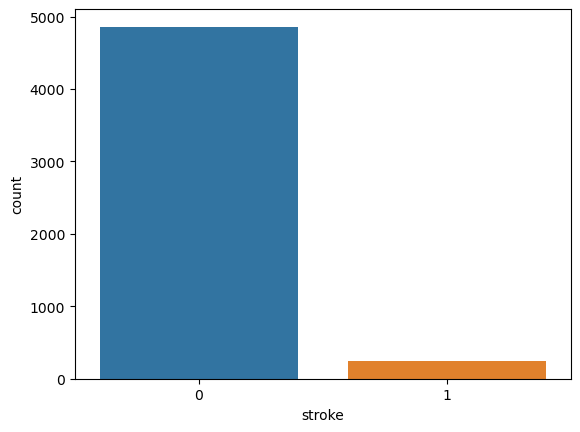

In [60]:
sns.countplot(x="stroke", data=df)


In [61]:
mean_bmi = df.groupby("stroke")["bmi"].agg(pd.Series.mean)
mean_bmi


stroke
0    28.823064
1    30.471292
Name: bmi, dtype: float64

In [62]:
df.loc[(df.stroke == 0) & (df.bmi.isna()), "bmi"] = mean_bmi[0]
df.loc[(df.stroke == 1) & (df.bmi.isna()), "bmi"] = mean_bmi[1]


In [63]:
df.isna().sum()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Data visualization


## Probability density function (PDF) of avg_glucose_level, age, bmi


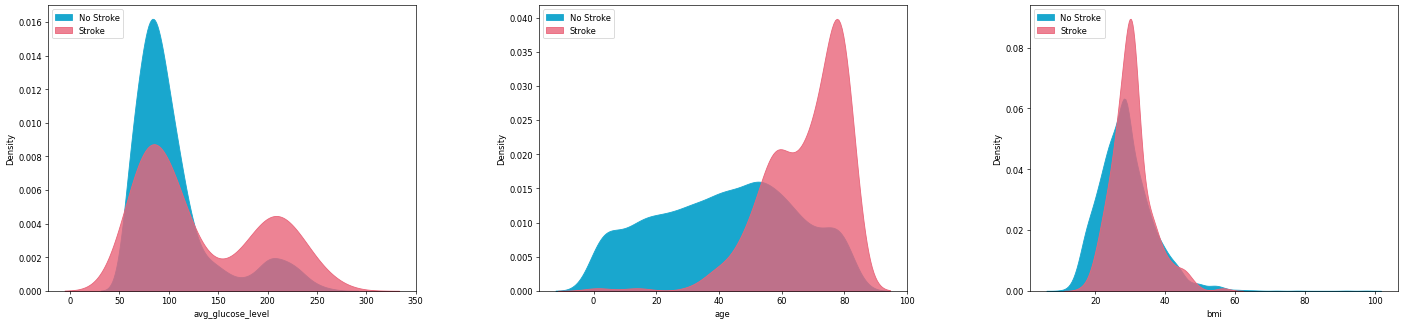

In [64]:
fig = plt.figure(figsize=(50, 15), dpi=60)
gs = GridSpec(ncols=28, nrows=12, left=0.05, right=0.5, wspace=1, hspace=0.1)

ax1 = fig.add_subplot(gs[1:6, 0:8])
ax2 = fig.add_subplot(gs[1:6, 10:18])
ax3 = fig.add_subplot(gs[1:6, 20:])

# Define colors
stroke_color = "#E96479"
not_stroke_color = "#19A7CE"

# Average Glucose Level
sns.kdeplot(
    x="avg_glucose_level",
    data=df[df.stroke == 0],
    ax=ax1,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="avg_glucose_level",
    data=df[df.stroke == 1],
    ax=ax1,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax1.legend(loc="upper left")

# Age
sns.kdeplot(
    x="age",
    data=df[df.stroke == 0],
    ax=ax2,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="age",
    data=df[df.stroke == 1],
    ax=ax2,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax2.legend(loc="upper left")

# BMI
sns.kdeplot(
    x="bmi",
    data=df[df.stroke == 0],
    ax=ax3,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="bmi",
    data=df[df.stroke == 1],
    ax=ax3,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax3.legend(loc="upper left")


# Data preprocessing


In [65]:
# explore categorical features (also known as nominal feature, are variables that contain label values rather than numeric values and often limited to a fixed set)

for col in ["gender", "work_type", "Residence_type", "smoking_status"]:
    print(f"{col}: {df[col].value_counts().to_dict()}")
    print("")


gender: {'Female': 2994, 'Male': 2115, 'Other': 1}

work_type: {'Private': 2925, 'Self-employed': 819, 'children': 687, 'Govt_job': 657, 'Never_worked': 22}

Residence_type: {'Urban': 2596, 'Rural': 2514}

smoking_status: {'never smoked': 1892, 'Unknown': 1544, 'formerly smoked': 885, 'smokes': 789}



In [66]:
# delete row with values = 'Other' in column 'Gender'

# outliner = ['Other']
# df = df[~df.gender.isin(outliner)]
# df[df.gender == 'Other']


# Data Binning


In [67]:
df["bmi_bin"] = pd.qcut(df["bmi"], q=4)
df["avg_glucose_level_bin"] = pd.cut(df["avg_glucose_level"], bins=[
    0, 100, 125, 150, 200, 300])
# , labels=['Low', 'Normal', 'High', 'Very High']


In [68]:
df["bmi_bin"].value_counts(sort=True)


(10.299000000000001, 23.8]    1294
(23.8, 28.4]                  1282
(28.4, 32.8]                  1271
(32.8, 97.6]                  1263
Name: bmi_bin, dtype: int64

In [69]:
df["avg_glucose_level_bin"].value_counts(sort=True)


(0, 100]      3131
(100, 125]     979
(200, 300]     434
(150, 200]     296
(125, 150]     270
Name: avg_glucose_level_bin, dtype: int64

In [70]:
df["avg_glucose_level_bin"] = pd.cut(
    df["avg_glucose_level"],
    bins=[0, 100, 125, 150, 200, 300],
    labels=["Low", "Normal", "High", "Very High", "Extremely High"],
)


In [71]:
df["bmi_bin"] = pd.qcut(
    df["bmi"],
    q=4,
    labels=["Underweight", "Normal", "Overweight", "Obese"],
)


In [72]:
df


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Extremely High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.471292,never smoked,1,Overweight,Extremely High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Overweight,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Very High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.823064,never smoked,0,Overweight,Low
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,Obese,High
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,Overweight,Low
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0,Normal,Very High


In [73]:
temp = df[df.gender == "Other"]
temp


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,Underweight,High


In [74]:
df = df[df.gender != "Other"]


In [75]:
X = df.drop(["id", "avg_glucose_level", "bmi", "stroke"], axis=1)
y = df["stroke"]


In [76]:
temp_X = temp.drop(["id", "avg_glucose_level", "bmi", "stroke"], axis=1)
temp_y = temp["stroke"]


In [77]:
X.shape


(5109, 10)

- Encoding data:
  - One-hot encoding: used for categorical data
  - Ordinal encoding: used for ordinal data


In [78]:
# create column transformer
ct = make_column_transformer(
    (OneHotEncoder(drop="first"), ["gender"]),
    (OneHotEncoder(drop="first"), ["ever_married"]),
    (OneHotEncoder(drop="first"), ["work_type"]),
    (OneHotEncoder(drop="first"), ["Residence_type"]),
    (
        OrdinalEncoder(
            categories=[["never smoked", "Unknown", "formerly smoked", "smokes"]]),
        ["smoking_status"],
    ),
    (
        OrdinalEncoder(
            categories=[["Low", "Normal", "High", "Very High", "Extremely High"]]),
        ["avg_glucose_level_bin"],
    ),
    (
        OrdinalEncoder(
            categories=[["Underweight", "Normal", "Overweight", "Obese"]]),
        ["bmi_bin"],
    ),
)


In [79]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, stratify=y, random_state=101)


In [80]:
X_train


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,bmi_bin,avg_glucose_level_bin
4066,Male,79.0,0,0,No,Self-employed,Urban,Unknown,Overweight,High
1076,Male,27.0,0,0,No,Private,Rural,never smoked,Normal,Low
2562,Female,59.0,0,0,Yes,Private,Rural,Unknown,Normal,Normal
5030,Male,21.0,0,0,Yes,Private,Rural,never smoked,Normal,Low
4668,Male,44.0,0,0,No,Self-employed,Urban,formerly smoked,Overweight,Normal
...,...,...,...,...,...,...,...,...,...,...
1279,Male,66.0,0,0,No,Private,Urban,never smoked,Normal,Normal
1136,Male,62.0,0,0,Yes,Govt_job,Urban,Unknown,Normal,Low
329,Female,18.0,0,0,No,Private,Rural,smokes,Obese,Normal
1025,Female,53.0,0,0,Yes,Private,Urban,Unknown,Overweight,Low


In [81]:
temp_X


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,bmi_bin,avg_glucose_level_bin
3116,Other,26.0,0,0,No,Private,Rural,formerly smoked,Underweight,High


In [82]:
X_train = pd.concat([X_train, temp_X], axis=0)


In [83]:
y_train = pd.concat([y_train, temp_y], axis=0)


In [84]:
X_train.shape, y_train.shape


((3832, 10), (3832,))

In [85]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)


<Axes: ylabel='count'>

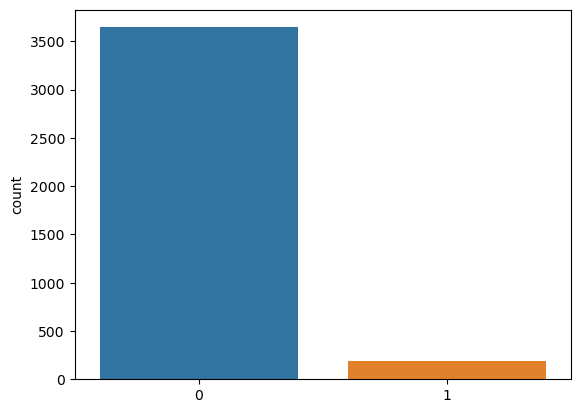

In [86]:
sns.countplot(x=y_train.ravel())


In [87]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.9514866979655712
Recall: 0.0
Precision: 0.0
F1-score: 0.0


In [88]:
def plotConFusionMatrix(y_test, y_pred):
    cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")


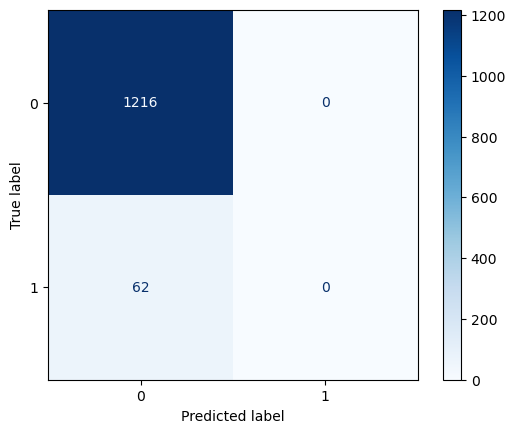

In [89]:
plotConFusionMatrix(y_test, y_pred_svc)


In [90]:
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_dt)}')
print(f'Recall: {recall_score(y_test, y_pred_dt)}')
print(f'Precision: {precision_score(y_test, y_pred_dt)}')
print(f'F1-score: {f1_score(y_test, y_pred_dt)}')


Accuracy: 0.9366197183098591
Recall: 0.04838709677419355
Precision: 0.12
F1-score: 0.0689655172413793


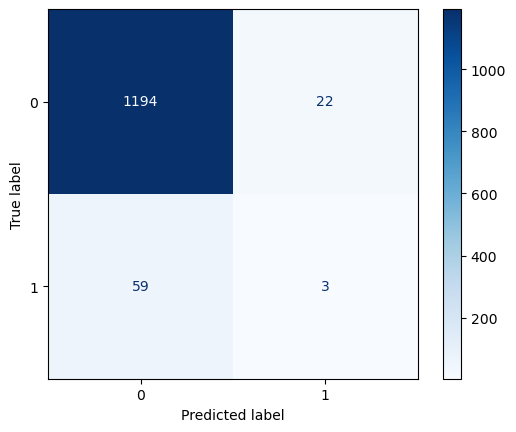

In [91]:
plotConFusionMatrix(y_test, y_pred_dt)


### It can be seen that the data is not balanced, therefore the model will be biased towards the majority class. Although the accuracy is high, the model is not good because the recall score is low (0%) (many stroke patients are predicted as non-stroke patients), which is very dangerous in the medical field.

### To solve this problem, we will use SMOTE (Synthetic Minority Over-sampling Technique) to balance the data.


In [92]:
oversample = SMOTE(k_neighbors=4, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)


<Axes: xlabel='stroke', ylabel='count'>

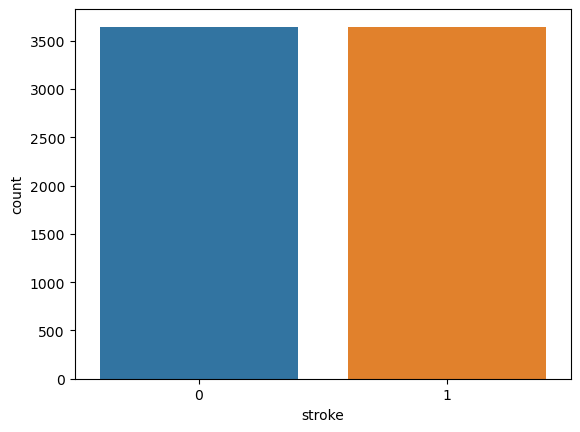

In [93]:
sns.countplot(x=y_train)


In [94]:
X_train.shape, y_train.shape


((7290, 11), (7290,))

In [95]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Training SVM model with no hyperparameter tuning


In [96]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.7456964006259781
Recall: 0.45161290322580644
Precision: 0.0877742946708464
F1-score: 0.14698162729658792


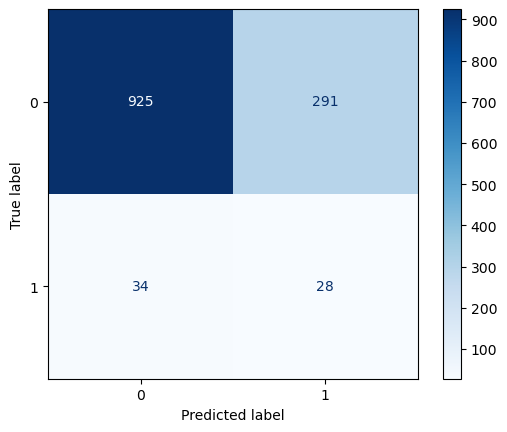

In [97]:
plotConFusionMatrix(y_test, y_pred_svc)


### Training Decision Tree model with no hyperparameter tuning


In [98]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"F1-score: {f1_score(y_test, y_pred_dt)}")


Accuracy: 0.9139280125195618
Recall: 0.04838709677419355
Precision: 0.05555555555555555
F1-score: 0.05172413793103448


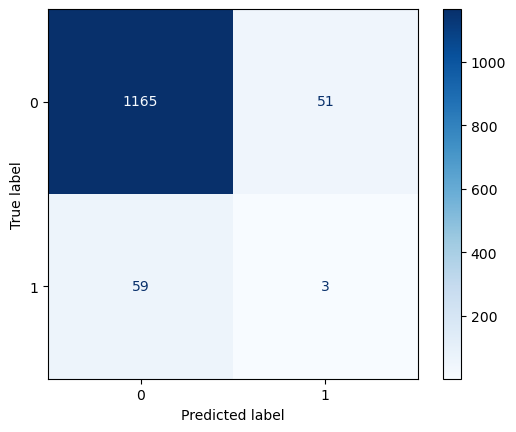

In [99]:
plotConFusionMatrix(y_test, y_pred_dt)


In [100]:
# importing libraries
from sklearn import decomposition
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [101]:
# Creating an standardscaler object
std_slc = StandardScaler()

# Creating a pca object
pca = decomposition.PCA()

# Creating a DecisionTreeClassifier
dec_tree = tree.DecisionTreeClassifier()

# Creating a pipeline of three steps. First, standardizing the data.
# Second, tranforming the data with PCA.
# Third, training a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('dec_tree', dec_tree)])

# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1, X_train.shape[1]+1, 1))

# Creating lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = np.arange(2, 10)
min_samples_split_values = np.arange(2, 10)

# Creating a dictionary of all the parameter options
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split_values)

# Specify scoring metric as 'recall' instead of the default 'accuracy'
scoring = 'recall'

# Creating a grid search object with the scoring metric
clf_GS = GridSearchCV(pipe, parameters, scoring=scoring)

# Fitting the grid search
clf_GS.fit(X_train, y_train)

# Viewing The Best Parameters
print('Best max_depth:', clf_GS.best_estimator_.get_params()
      ['dec_tree__max_depth'])
print('Best criterion:', clf_GS.best_estimator_.get_params()
      ['dec_tree__criterion'])
print('Best min_samples_split:', clf_GS.best_estimator_.get_params()
      ['dec_tree__min_samples_split'])

# print(clf_GS.best_estimator_.get_params()['dec_tree'])


Best max_depth: 2
Best criterion: entropy
Best min_samples_split: 2


### Training Decision Tree model with optimal hyperparameter tuning


In [102]:
dt_model = DecisionTreeClassifier(
    criterion=clf_GS.best_estimator_.get_params()['dec_tree__criterion'],
    max_depth=clf_GS.best_estimator_.get_params(
    )['dec_tree__max_depth'], min_samples_split=clf_GS.best_estimator_.get_params()['dec_tree__min_samples_split'],
    random_state=42)
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_dt)}')
print(f'Recall: {recall_score(y_test, y_pred_dt)}')
print(f'Precision: {precision_score(y_test, y_pred_dt)}')
print(f'F1-score: {f1_score(y_test, y_pred_dt)}')


Accuracy: 0.38810641627543035
Recall: 0.8548387096774194
Precision: 0.06416464891041163
F1-score: 0.11936936936936937


### => It can be seen that the recall score of the Decision Tree model increase from 4.8% to 85.4% after hyperparameter tuning.


### Visualize the Confusion Matrix


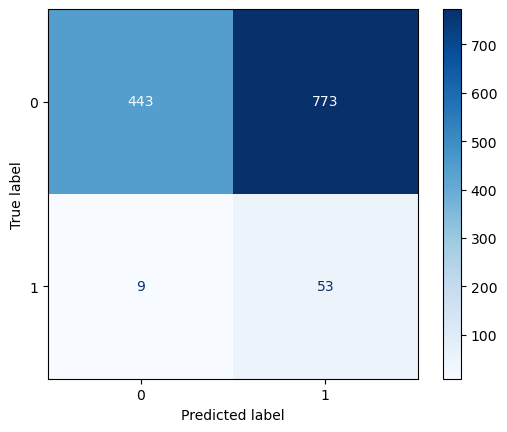

In [103]:
# confusion matrix
plotConFusionMatrix(y_test, y_pred_dt)


### Visualize the Decision Tree model


In [104]:
from sklearn import tree
text_representation = tree.export_text(dt_model)
print(text_representation)


|--- feature_2 <= 0.00
|   |--- feature_10 <= 0.33
|   |   |--- class: 0
|   |--- feature_10 >  0.33
|   |   |--- class: 0
|--- feature_2 >  0.00
|   |--- feature_9 <= 0.50
|   |   |--- class: 1
|   |--- feature_9 >  0.50
|   |   |--- class: 1



### Training SVM model with optimal hyperparameters


In [105]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01]
              }

# defining the scoring metric as recall
scoring = make_scorer(recall_score)

# creating the GridSearchCV object with the custom scoring metric
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, scoring=scoring)

# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.815 total time=   1.1s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.849 total time=   1.2s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.830 total time=   1.1s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.844 total time=   1.1s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.853 total time=   1.1s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.925 total time=   1.3s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.934 total time=   1.3s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.916 total time=   1.2s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.929 total time=   1.3s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.933 total time=   1.3s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.915 total time=   1.5s
[CV 2/5] END .................C=0.1, gamma=0.01;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(recall_score), verbose=3)

In [106]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 0.1, 'gamma': 0.1}
SVC(C=0.1, gamma=0.1)


In [107]:
svc_model = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.39436619718309857
Recall: 0.8225806451612904
Precision: 0.06265356265356266
F1-score: 0.11643835616438357


### => It can be seen that the recall score of the SVM model increase from 45.2% to 82.3% after hyperparameter tuning.
